In [ ]:
import xarray as xr
import sys, os


sys.path.append(os.path.abspath(os.path.join('..')))

import pycomlink as pycml
from pycomlink.processing import pytorch_util
# from cml_wd_pytorch.inference import run_inference # old, 

c:\Users\lukas\OneDrive - VUT\TelcoSense\pycomlink\pycomlink\io\examples.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [4]:
# Load data

data_path = pycml.io.examples.get_example_data_path()
cmls = xr.open_dataset(data_path + '/example_cml_data.nc')

# select 3 different CMLs to study
cmls = cmls.isel(cml_id = [0, 10, 370])

# Remove outliers, compute tl and interpolate missing values
cmls['tsl'] = cmls.tsl.where(cmls.tsl != 255.0)
cmls['rsl'] = cmls.rsl.where(cmls.rsl != -99.9)
cmls['tl'] = cmls.tsl - cmls.rsl # calculate total loss (previous TRSL)
cmls['tl'] = cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

In [ ]:
run_inference.test_cnn_wd()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/chwala-c/miniforge3/envs/pycomlink-dev/lib/python3.12/data/dummy_model/model_epoch_0.pth'

In [4]:
#model_path = '/Users/chwala-c/code/pycomlink/pycomlink/processing/wet_dry/cml_wd_pytorch/data/dummy_model/model_epoch_0.pth'
model_path = '/Users/chwala-c/code/pycomlink/pycomlink/processing/wet_dry/cml_wd_pytorch/data/dummy_model/model_epoch_15.pth'

In [5]:
# Dataarray shape is expected to be (time, channels, cml_id).
cmls.tl.transpose('time', 'channel_id', 'cml_id')

<xarray.DataArray 'tl' (time: 15840, channel_id: 2, cml_id: 3)> Size: 760kB
array([[[60. , 53.9, 72.4],
        [55.7, 55.1, 61.1]],

       [[59. , 53.9, 72.4],
        [55.7, 55.1, 61.1]],

       [[58.7, 53.9, 72.4],
        [56. , 55.1, 61.1]],

       ...,

       [[59. , 54.5, 57. ],
        [57. , 55.5, 60.2]],

       [[58.7, 54.2, 57. ],
        [56.7, 55.5, 60.2]],

       [[58.7, 54.5, 57. ],
        [57. , 55.5, 60.2]]], shape=(15840, 2, 3))
Coordinates:
  * time              (time) datetime64[ns] 127kB 2018-05-10 ... 2018-05-20T2...
  * cml_id            (cml_id) <U3 36B '0' '10' '370'
    length            (cml_id) float64 24B 6.179 2.862 5.721
    site_a_latitude   (cml_id) float64 24B 58.26 58.05 57.89
    site_a_longitude  (cml_id) float64 24B 1.388 1.34 1.292
    site_b_latitude   (cml_id) float64 24B 58.25 58.04 57.83
    site_b_longitude  (cml_id) float64 24B 1.304 1.378 1.298
  * channel_id        (channel_id) <U9 72B 'channel_1' 'channel_2'
    frequency         (channel_id, cml_id) float64 48B 2.491e+10 ... 2.486e+10
    polarization      (channel_id, cml_id) <U1 24B 'V' 'V' 'V' 'V' 'V' 'V'

In [6]:
tl = cmls.tl.transpose('time', 'channel_id', 'cml_id')
tl_normed = tl - tl.median(dim='time')

In [7]:
# cmls['cml_id'] = range(len(cmls['cml_id']))
# cmls['time'] = range(len(cmls['time']))

result = run_inference.cnn_wd(model_path_or_run_id=model_path, data=tl_normed)

In [8]:
result

<xarray.Dataset> Size: 1MB
Dimensions:           (time: 15840, cml_id: 3, channel_id: 2)
Coordinates:
  * time              (time) datetime64[ns] 127kB 2018-05-10 ... 2018-05-20T2...
  * cml_id            (cml_id) <U3 36B '0' '10' '370'
    length            (cml_id) float64 24B 6.179 2.862 5.721
    site_a_latitude   (cml_id) float64 24B 58.26 58.05 57.89
    site_a_longitude  (cml_id) float64 24B 1.388 1.34 1.292
    site_b_latitude   (cml_id) float64 24B 58.25 58.04 57.83
    site_b_longitude  (cml_id) float64 24B 1.304 1.378 1.298
  * channel_id        (channel_id) <U9 72B 'channel_1' 'channel_2'
    frequency         (channel_id, cml_id) float64 48B 2.491e+10 ... 2.486e+10
    polarization      (channel_id, cml_id) <U1 24B 'V' 'V' 'V' 'V' 'V' 'V'
Data variables:
    TL                (time, channel_id, cml_id) float64 760kB 1.0 -0.6 ... -0.6
    predictions       (time, cml_id) float64 380kB nan nan nan ... nan nan nan

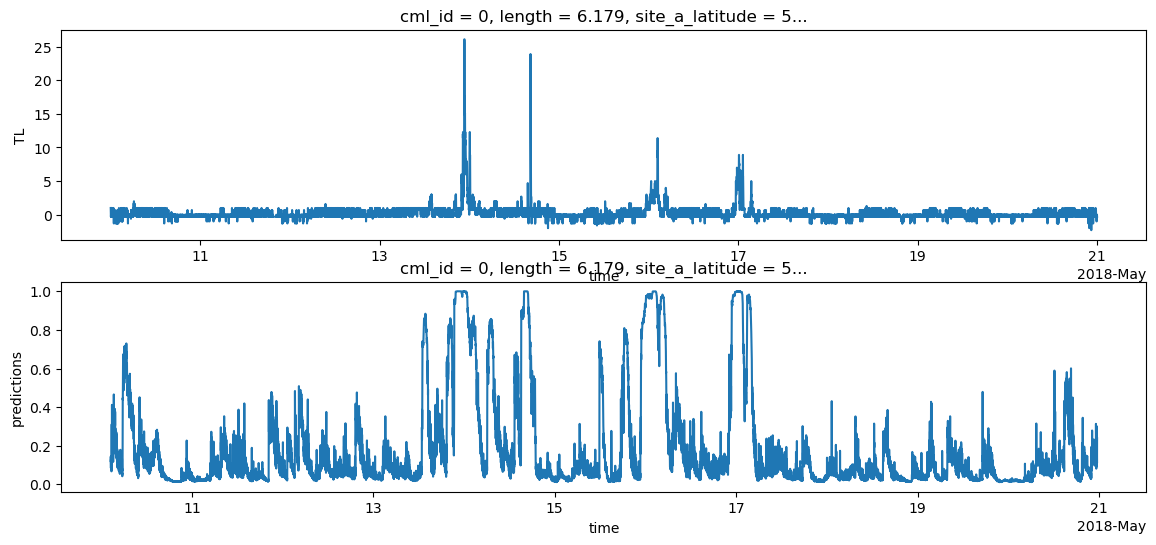

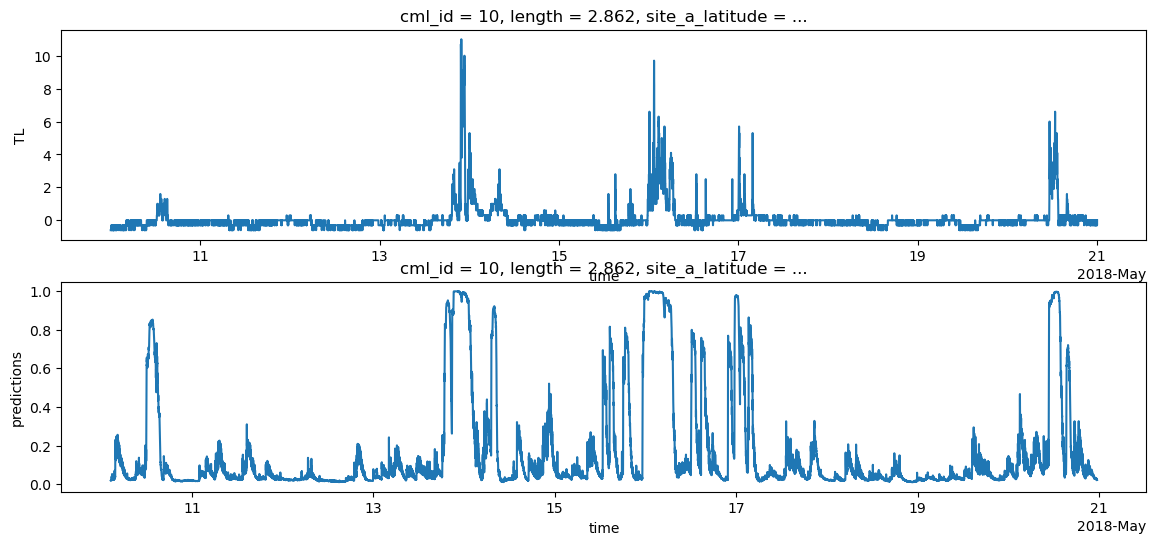

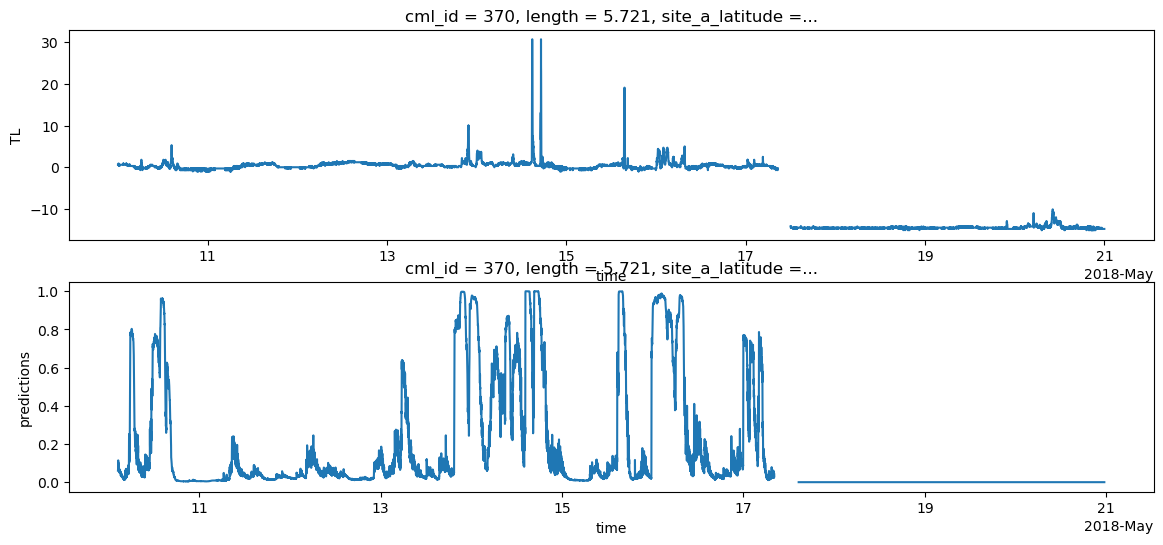

In [9]:
import matplotlib.pyplot as plt

for cml_id in cmls.cml_id.data:
    fig, axs = plt.subplots(2, 1, figsize=(14, 6))
    result.TL.sel(cml_id=cml_id).isel(channel_id=0).plot.line(x='time', ax=axs[0])
    result.predictions.sel(cml_id=cml_id).plot.line(x='time');
    
